In [1]:
import json
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)

In [2]:
df_main3 = pd.read_pickle("df_main3.pkl")
df_refer2 = pd.read_pickle("df_refer2.pkl")

In [21]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_refer_for_scaler = df_refer2[['BoW_Jac','BoW_Cos','BoW_Euc','tfidf_Jac','tfidf_Cos','tfidf_Euc','w2v_Cos_x']]

df_refer_scaled = scaler.fit_transform(df_refer_for_scaler.to_numpy())
df_refer_scaled = pd.DataFrame(df_refer_scaled)


df_refer_scaled.describe()

#Should I scale similarity scores or not? (already percentage)

,0,1,2,3,4,5,6
count,14271.000000,14271.000000,14271.000000,14271.000000,14271.000000,14271.000000,14271.000000
mean,0.459860,0.520299,0.803699,0.703329,0.389592,0.245107,0.965985
std,0.163492,0.119454,0.054771,0.059173,0.115924,0.085510,0.037733
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.357125,0.444803,0.776609,0.666467,0.311634,0.187707,0.961195
50%,0.468750,0.524476,0.810730,0.714457,0.386637,0.238842,0.971164
75%,0.568125,0.600977,0.839037,0.739052,0.462549,0.293802,0.978077
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:xlabel='weighted_avg_ref_citations_y'>

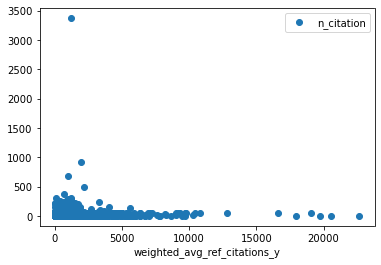

In [33]:
df_main3.plot(x='weighted_avg_ref_citations_y', y='n_citation',  style='o')



In [4]:
sum_similarity_weight = pd.pivot_table(df_refer2, values=['w2v_Cos'], 
                                                    index=['id'], columns=None, aggfunc='sum')

df_refer2 = pd.merge(df_refer2, sum_similarity_weight,  on='id')
df_main3 = pd.merge(df_main3, sum_similarity_weight,  on='id')

/var/folders/0p/nwgqr7892g1dtzj6b8r82hm00000gn/T/ipykernel_71372/1075338331.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'w2v_Cos_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_main3 = pd.merge(df_main3, sum_similarity_weight,  on='id')


In [6]:
df_refer2.rename(columns= {'w2v_Cos_y':'sum_similarity_weight'}, inplace=True)

In [7]:
df_refer2['weightvalue'] = df_refer2['w2v_Cos_x'] * df_refer2['ref_n_citation']

In [12]:
df_refer2['weighted_avg_ref_citations'] =  df_refer2['weightvalue']/df_refer2['sum_similarity_weight']

In [13]:
weight_value = pd.pivot_table(df_refer2, values=['weighted_avg_ref_citations'], 
                                                    index=['id'], columns=None, aggfunc='sum')
df_main3 = pd.merge(df_main3, weight_value,  on='id')


In [34]:
df_main3.drop(['weighted_avg_ref_citations_x'], inplace=True, axis=1)

In [ ]:
#Quality of English writing judging from abstracts
# 1. # of verbs compared to nouns
# 2. Readability 
# 3. % of passive voice

In [ ]:
#1. actions verbs 
import nltk
from collections import Counter

for index, row in df_main3.iterrows():
    text = row['abstract']
    tokens = nltk.word_tokenize(text.lower())
    text = nltk.Text(tokens)
    tagged = nltk.pos_tag(text)
    counts = Counter(tag for word, tag in tagged)

#2. Readability

Advantages of Readability Formulae:
1. Readability formulas measure the grade-level readers must have to be to read a given text. Thus provides the writer of the text with much-needed information to reach his target audience. 
2. Know beforehand if the target audience can understand your content.
3. Easy-to-use. 
4. A readable text attracts more audience. 

Disadvantages of Readability Formulae:
1. Due to many readability formulas, there is an increasing chance of getting wide variations in results of a same text. 
2. Applies Mathematics to Literature which isn’t always a good idea.
3. Cannot measure the complexity of a word or phrase to pinpoint where you need to correct it. 



In [50]:
import spacy

from textstat.textstat import textstatistics

# Splits the text into sentences, using
# Spacy's sentence segmentation which can
# be found at https://spacy.io/usage/spacy-101
def break_sentences(text):
	nlp = spacy.load('en_core_web_sm')
	doc = nlp(text)
	return list(doc.sents)

# Returns Number of Words in the text
def word_count(text):
	sentences = break_sentences(text)
	words = 0
	for sentence in sentences:
		words += len([token for token in sentence])
	return words

# Returns the number of sentences in the text
def sentence_count(text):
	sentences = break_sentences(text)
	return len(sentences)

# Returns average sentence length
def avg_sentence_length(text):
	words = word_count(text)
	sentences = sentence_count(text)
	average_sentence_length = float(words / sentences)
	return average_sentence_length

# Textstat is a python package, to calculate statistics from
# text to determine readability,
# complexity and grade level of a particular corpus.
# Package can be found at https://pypi.python.org/pypi/textstat
def syllables_count(word):
	return textstatistics().syllable_count(word)

# Returns the average number of syllables per
# word in the text
def avg_syllables_per_word(text):
	syllable = syllables_count(text)
	words = word_count(text)
	ASPW = float(syllable) / float(words)
	return ASPW

# Return total Difficult Words in a text
def difficult_words(text):
	
	nlp = spacy.load('en_core_web_sm')
	doc = nlp(text)
	# Find all words in the text
	words = []
	sentences = break_sentences(text)
	for sentence in sentences:
		words += [str(token) for token in sentence]

	# difficult words are those with syllables >= 2
	# easy_word_set is provide by Textstat as
	# a list of common words
	diff_words_set = set()
	
	for word in words:
		syllable_count = syllables_count(word)
		if word not in nlp.Defaults.stop_words and syllable_count >= 2:
			diff_words_set.add(word)

	return len(diff_words_set)

# A word is polysyllablic if it has more than 3 syllables
# this functions returns the number of all such words
# present in the text
def poly_syllable_count(text):
	count = 0
	words = []
	sentences = break_sentences(text)
	for sentence in sentences:
		words += [token for token in sentence]
	

	for word in words:
		syllable_count = syllables_count(word)
		if syllable_count >= 3:
			count += 1
	return count


def flesch_reading_ease(text):
	"""
		Implements Flesch Formula:
		Reading Ease score = 206.835 - (1.015 × ASL) - (84.6 × ASW)
		Here,
		ASL = average sentence length (number of words
				divided by number of sentences)
		ASW = average word length in syllables (number of syllables
				divided by number of words)
	"""
	FRE = 206.835 - float(1.015 * avg_sentence_length(text)) -\
		float(84.6 * avg_syllables_per_word(text))
	return FRE


def gunning_fog(text):
	per_diff_words = (difficult_words(text) / word_count(text) * 100) + 5
	grade = 0.4 * (avg_sentence_length(text) + per_diff_words)
	return grade


def smog_index(text):
	"""
		Implements SMOG Formula / Grading
		SMOG grading = 3 + ?polysyllable count.
		Here,
		polysyllable count = number of words of more
		than two syllables in a sample of 30 sentences.
	"""

	if sentence_count(text) >= 3:
		poly_syllab = poly_syllable_count(text)
		SMOG = (1.043 * (30*(poly_syllab / sentence_count(text)))**0.5) \
				+ 3.1291
		return SMOG
	else:
		return 0


def dale_chall_readability_score(text):
	"""
		Implements Dale Challe Formula:
		Raw score = 0.1579*(PDW) + 0.0496*(ASL) + 3.6365
		Here,
			PDW = Percentage of difficult words.
			ASL = Average sentence length
	"""
	words = word_count(text)
	# Number of words not termed as difficult words
	count = word_count - difficult_words(text)
	if words > 0:

		# Percentage of words not on difficult word list

		per = float(count) / float(words) * 100
	
	# diff_words stores percentage of difficult words
	diff_words = 100 - per

	raw_score = (0.1579 * diff_words) + \
				(0.0496 * avg_sentence_length(text))
	
	# If Percentage of Difficult Words is greater than 5 %, then;
	# Adjusted Score = Raw Score + 3.6365,
	# otherwise Adjusted Score = Raw Score

	if diff_words > 5:	

		raw_score += 3.6365
		
	return score


In [ ]:
readability_score =[]
for index, row in df_main3.iterrows():
    
    score = flesch_reading_ease(row['abstract'])
    readability_score.append(score)
    

In [ ]:
readability_score2 =[]
for index, row in df_main3.iterrows():
    score = smog_index(row['abstract'])
    readability_score2.append(score)
    
